In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import ast
import json
import numpy as np
import os
import re
from sklearn.linear_model import LinearRegression

# Read runtimes from logfiles

In [3]:
def read_all_logfiles_in_directory(logfile_directory):
    runtimes = {}
    for logfile_name in os.listdir(logfile_directory):
        model = logfile_name.replace(".log", "")
        logfile_full_path = os.path.join(logfile_directory, logfile_name)
        with open(logfile_full_path, 'r') as f:
            for line in f:
                m = re.match(r'Runtime for (.*): (\d+\.\d+) seconds', line)
                if m is not None:
                    label = ast.literal_eval(m.group(1))
                    label['model'] = model
                    runtime = float(m.group(2))
                    runtimes[(label['model'], label['num_input_tokens'],
                              label['num_output_tokens'])] = runtime
    return runtimes

In [4]:
v100_runtimes = read_all_logfiles_in_directory("logs/v100")
a100_runtimes = read_all_logfiles_in_directory("logs/a100")

# Plot runtimes versus number of output tokens to verify linearity

In [5]:
def plot_per_model_runtimes(runtimes, model, all_num_input_tokens):
    print(model)

    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    for num_input_tokens in all_num_input_tokens:
        num_output_tokens_and_runtimes = []
        for label, runtime in runtimes.items():
            if label[0] == model and label[1] == num_input_tokens:
                num_output_tokens_and_runtimes.append((label[2], runtime))
        ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                [y for (_, y) in num_output_tokens_and_runtimes],
                label=f"input_tokens={num_input_tokens}",
                marker='o')

    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel("Number of output tokens")
    ax.set_ylabel("Runtime (seconds)")
    plt.legend(frameon=False)    
    sns.despine()
    plt.show()

openai_davinci


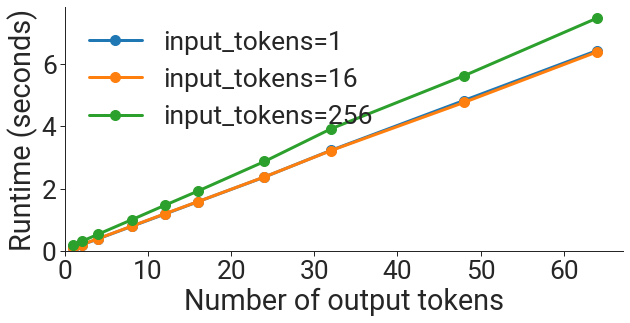

ai21_j1_jumbo


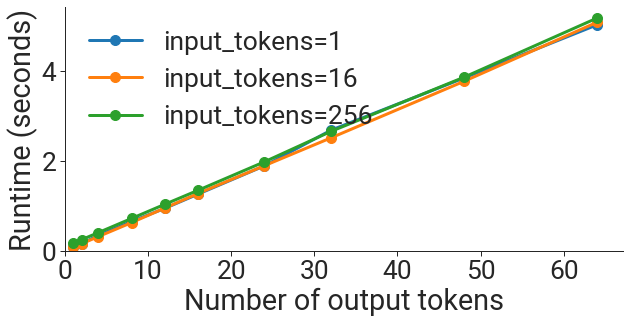

In [6]:
# Plot V100 runtimes.
plot_per_model_runtimes(v100_runtimes, 'openai_davinci', [1, 16, 256])
plot_per_model_runtimes(v100_runtimes, 'ai21_j1_jumbo', [1, 16, 256])

openai_davinci


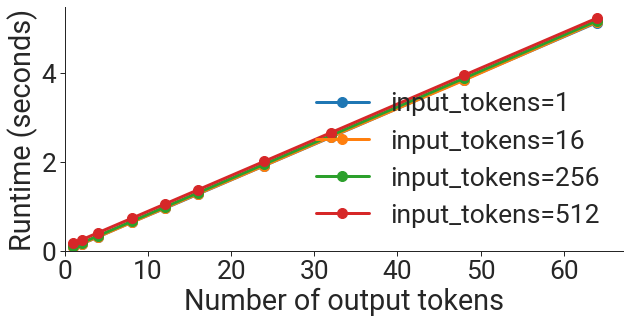

ai21_j1_jumbo


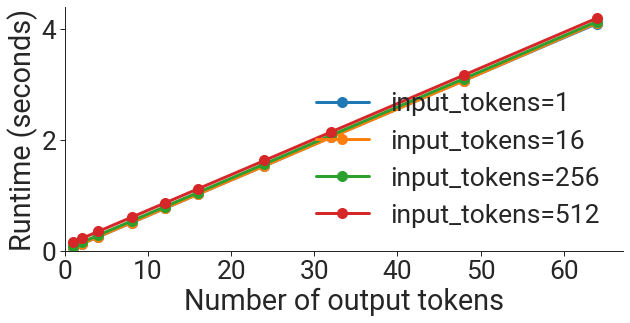

In [7]:
# Plot A100 runtimes.
plot_per_model_runtimes(a100_runtimes, 'openai_davinci', [1, 16, 256, 512])
plot_per_model_runtimes(a100_runtimes, 'ai21_j1_jumbo', [1, 16, 256, 512])

# Get best-fit lines (slope and intercept)

In [8]:
import numpy as np

model_name_mapping = {
    "gptj_6b": ["huggingface/gptj_6b"],
    "openai_ada": ["openai/ada"],
    "openai_davinci": ["openai/davinci"],
    "ai21_j1_large": ["ai21/j1-large", "openai/curie"],
    "ai21_j1_jumbo": ["ai21/j1-jumbo"],
}

model_parameter_mapping = {
    # (hidden_size, num_layers, multi_gpu).
    "gptj_6b": (4096, 28, False),
    "openai_ada": (1024, 24, False),
    "openai_davinci": (12288, 96, True),
    "ai21_j1_large": (4096, 32, False),
    "ai21_j1_jumbo": (13824, 76, True),
}

VOCAB_SIZE = 50304

def compute_best_fit(runtimes, models, num_gpus, filename=None):
    json_obj = {}
    for model in models:
        model_obj = {}
        
        # Get all unique num_input_tokens.
        all_num_input_tokens = set()
        for label in runtimes:
            all_num_input_tokens.add(label[1])
        all_num_input_tokens = sorted(list(all_num_input_tokens))
        
        # Group runtimes by num_input_tokens.
        processed_runtimes = [[] for num_input_tokens in all_num_input_tokens]
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            for label, runtime in runtimes.items():
                if label[0] == model and label[1] == num_input_tokens:
                    processed_runtimes[i].append((label[2], runtime))
                    
        # Cost of embedding num_input_tokens is just the runtime when
        # num_output_tokens is equal to 1.
        runtime_for_input_tokens = {}
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            assert processed_runtimes[i][0][0] == 1
            runtime_for_input_tokens[num_input_tokens] = processed_runtimes[i][0][1]
            
        (hidden_size, num_layers, multi_gpu) = model_parameter_mapping[model]
        if multi_gpu:
            num_gpus_for_model = num_gpus
        else:
            num_gpus_for_model = 1

        # Perform regression between adjusted runtimes (end-to-end
        # runtime minus embedding runtime with num_input_tokens) and
        # number of output tokens, to obtain the runtime per generated
        # output token.
        num_output_tokens_and_runtimes = []
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            for label, runtime in runtimes.items():
                if label[0] == model and label[1] == num_input_tokens:
                    num_output_tokens_and_runtimes.append(
                        (label[2], runtime - runtime_for_input_tokens[num_input_tokens]))
        X = [[x] for (x, _) in num_output_tokens_and_runtimes]
        Y = [y for (_, y) in num_output_tokens_and_runtimes]
        reg = LinearRegression()
        reg.fit(X, Y)
        runtime_per_output_token = round(reg.coef_[0], 3)

        num_compute_operations = 24 * hidden_size**2 * num_layers
        throughput = num_compute_operations / (
            runtime_per_output_token * 10**12 * num_gpus_for_model)
        print(f"{model}:\n\tRuntime per output token = {runtime_per_output_token:.3f} seconds, "
              f"throughput = {throughput:.3f} TFLOP/s/GPU\n")
        model_obj['runtime_per_output_token'] = runtime_per_output_token
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            num_compute_operations = \
                24 * num_input_tokens * hidden_size**2 * num_layers * (
                1. + (num_input_tokens / (6 * hidden_size)) + (
                    VOCAB_SIZE / (16. * num_layers * hidden_size)))
            runtime = runtime_for_input_tokens[num_input_tokens]
            throughput = num_compute_operations / (
                runtime * 10**12 * num_gpus_for_model)
            print(f"\tRuntime for {num_input_tokens} input token(s) = {runtime:.3f} seconds, "
                  f"throughput = {throughput:.3f} TFLOP/s/GPU")
        print()
        
        square_errors = []
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            for label, runtime in runtimes.items():
                if label[0] == model and label[1] == num_input_tokens:
                    estimated_runtime = runtime_for_input_tokens[num_input_tokens] + (
                        (label[2] - 1) * runtime_per_output_token)
                    square_errors.append((runtime - estimated_runtime)**2)
        print(f"\tMean squared error: {np.mean(square_errors):.4f}")
        print(f"\tMaximum squared error: {max(square_errors):.4f}")
        print()

        model_obj['runtime_for_input_tokens'] = runtime_for_input_tokens
        for model_name in model_name_mapping[model]:
            json_obj[model_name] = model_obj
    print()
    
    if filename is not None:
        with open(filename, 'w') as f:
            json.dump(json_obj, f, indent=2)

In [9]:
# Compute best fit for V100 runtimes.
models = ["gptj_6b", "openai_ada", "openai_davinci", "ai21_j1_large", "ai21_j1_jumbo"]
compute_best_fit(v100_runtimes, models, num_gpus=16,
                 filename="processed_jsons/efficiency_v100.json")

gptj_6b:
	Runtime per output token = 0.024 seconds, throughput = 0.470 TFLOP/s/GPU

	Runtime for 1 input token(s) = 0.027 seconds, throughput = 0.429 TFLOP/s/GPU
	Runtime for 16 input token(s) = 0.028 seconds, throughput = 6.623 TFLOP/s/GPU
	Runtime for 32 input token(s) = 0.027 seconds, throughput = 13.746 TFLOP/s/GPU
	Runtime for 64 input token(s) = 0.035 seconds, throughput = 21.235 TFLOP/s/GPU
	Runtime for 128 input token(s) = 0.041 seconds, throughput = 36.346 TFLOP/s/GPU
	Runtime for 192 input token(s) = 0.050 seconds, throughput = 44.818 TFLOP/s/GPU
	Runtime for 256 input token(s) = 0.052 seconds, throughput = 57.604 TFLOP/s/GPU
	Runtime for 320 input token(s) = 0.067 seconds, throughput = 56.025 TFLOP/s/GPU
	Runtime for 384 input token(s) = 0.071 seconds, throughput = 63.601 TFLOP/s/GPU
	Runtime for 428 input token(s) = 0.094 seconds, throughput = 53.635 TFLOP/s/GPU
	Runtime for 472 input token(s) = 0.090 seconds, throughput = 61.884 TFLOP/s/GPU
	Runtime for 512 input token(s) 

In [10]:
# Compute best fit for A100 runtimes.
models = ["gptj_6b", "openai_ada", "openai_davinci", "ai21_j1_large", "ai21_j1_jumbo"]
compute_best_fit(a100_runtimes, models, num_gpus=8,
                 filename="processed_jsons/efficiency_a100.json")

gptj_6b:
	Runtime per output token = 0.021 seconds, throughput = 0.537 TFLOP/s/GPU

	Runtime for 1 input token(s) = 0.023 seconds, throughput = 0.504 TFLOP/s/GPU
	Runtime for 16 input token(s) = 0.024 seconds, throughput = 7.727 TFLOP/s/GPU
	Runtime for 32 input token(s) = 0.023 seconds, throughput = 16.136 TFLOP/s/GPU
	Runtime for 64 input token(s) = 0.023 seconds, throughput = 32.314 TFLOP/s/GPU
	Runtime for 128 input token(s) = 0.024 seconds, throughput = 62.091 TFLOP/s/GPU
	Runtime for 192 input token(s) = 0.025 seconds, throughput = 89.637 TFLOP/s/GPU
	Runtime for 256 input token(s) = 0.025 seconds, throughput = 119.816 TFLOP/s/GPU
	Runtime for 320 input token(s) = 0.030 seconds, throughput = 125.122 TFLOP/s/GPU
	Runtime for 384 input token(s) = 0.032 seconds, throughput = 141.114 TFLOP/s/GPU
	Runtime for 428 input token(s) = 0.041 seconds, throughput = 122.969 TFLOP/s/GPU
	Runtime for 472 input token(s) = 0.041 seconds, throughput = 135.843 TFLOP/s/GPU
	Runtime for 512 input toke